In [45]:
# Clear variables
%reset

Nothing done.


## Libraries

In [94]:
import pandas as pd
import pm4py
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz-11.0.0-win64/bin/'
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

from main import print_log_info

from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator


## Variant Analysis


In [3]:
filtered_log_df = pd.read_csv('data\\sepsis_filtered_data_2024-06-13_16-10-42.csv', sep=',')
filtered_log_df['time:timestamp'] = pd.to_datetime(filtered_log_df['time:timestamp'])
filtered_log_df['case:concept:name'] = filtered_log_df['case:concept:name'].astype(str)

In [4]:
filtered_log = log_converter.apply(filtered_log_df)
variants = pm4py.get_variants(filtered_log)
variants_lengths = {key: len(value) for key, value in variants.items()}
sorted_variants_lengths = dict(sorted(variants_lengths.items(), key=lambda item: item[1], reverse=True))
for i, (key, length) in enumerate(sorted_variants_lengths.items()):
    print(f"Number of cases of each variant: {length} '\n' {key} ")
    if i == 10:  # Stop after printing the first 5 elements
        break

Number of cases of each variant: 11 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'LacticAcid', 'Leucocytes', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 8 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 7 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'CRP', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Release A') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'CRP', 'LacticAcid', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'Leucocytes', 'CRP', 'Release A') 
Number of cases of each variant: 4 '
' ('ER Registration', 'ER Triage', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'CRP'

## Preparing to Process Discovery
 - Characteristics of filtered Event Log
 - Rework Filter - analyze number of unique cases that contain one of repeated activities (LactidAcid, CRP, Leucocytes)
 - Directly Follow Relation - analyze which blood test ('CRP', 'Leucocytes', 'LacticAcid') is taken after each other
 - Activities Positions - analyze the positions of chosen activities that occur most frequently

####  Characteristics of filtered Event Log

In [16]:
num_events, num_cases = print_log_info(filtered_log_df)

filtered_activities = pm4py.get_event_attribute_values(filtered_log_df, "concept:name")

pprint(sorted(filtered_activities.items(), key=lambda x: x[1], reverse=True))
print("\nStart activities")
pprint(pm4py.get_start_activities(filtered_log_df, activity_key='concept:name'))
print("\nEnd activities")
pprint(pm4py.get_end_activities(filtered_log_df, activity_key='concept:name'))

Number of events: 10585 (100.00%)
Number of cases: 666 (100.00%)


[('Leucocytes', 2261),
 ('CRP', 2237),
 ('LacticAcid', 1052),
 ('Admission NC', 892),
 ('ER Triage', 667),
 ('ER Registration', 666),
 ('ER Sepsis Triage', 666),
 ('IV Antibiotics', 650),
 ('IV Liquid', 591),
 ('Release A', 523),
 ('Return ER', 226),
 ('Admission IC', 82),
 ('Release B', 37),
 ('Release C', 18),
 ('Release D', 14),
 ('Release E', 3)]

Start activities
{'ER Registration': 656, 'ER Sepsis Triage': 5, 'ER Triage': 5}

End activities
{'IV Antibiotics': 71,
 'Release A': 309,
 'Release B': 37,
 'Release C': 13,
 'Release D': 8,
 'Release E': 2,
 'Return ER': 226}


#### Rework Filter (filtering)

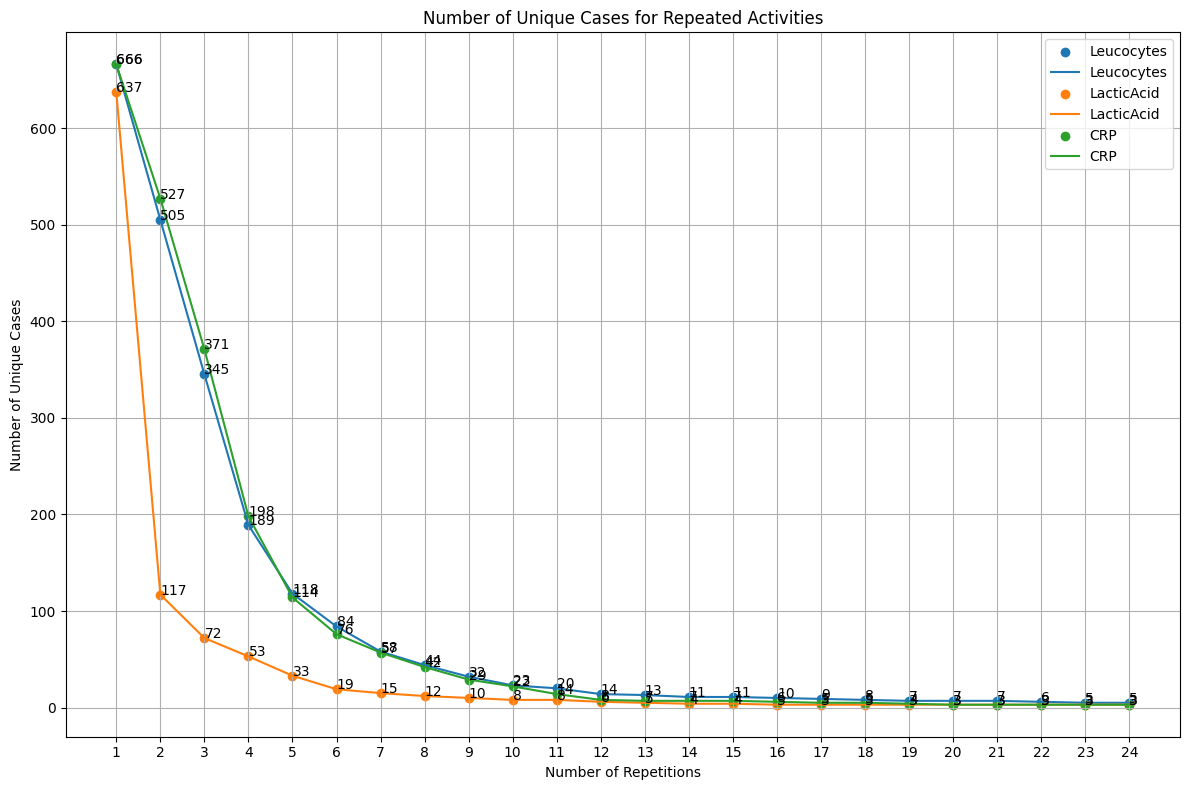

In [86]:
# Define the range
min_value = 1
max_value = 25

# Generate the array
repetitions_num = np.arange(min_value, max_value, 1)

# List of columns to process
columns = ["Leucocytes", "LacticAcid", "CRP"]

# Dictionary to store the results
results = {column: [] for column in columns}

# Assuming filtered_log_df is your DataFrame
for column in columns:
    for i in repetitions_num:
        d = pm4py.filter_activities_rework(filtered_log_df, column, i)
        results[column].append(len(d['case:concept:name'].unique()))

# Plotting the results for each column
plt.figure(figsize=(12, 8))
# plt.figure(figsize=(24, 16))

for column in columns:
    plt.scatter(repetitions_num, results[column], label=column)
    plt.plot(repetitions_num, results[column], label=column)
    for rep_num, result in zip(repetitions_num, results[column]):
        plt.annotate(result, (rep_num, result))

plt.xlabel('Number of Repetitions')
plt.ylabel('Number of Unique Cases')
plt.title('Number of Unique Cases for Repeated Activities')
plt.legend()
plt.xticks(ticks=np.arange(min_value, max_value, 1))  # Adjust ticks for better readability
plt.tight_layout()
plt.grid()
# Show the plot
plt.show()

# plt.savefig('charts\\repetitions_per_case.png', dpi=300, bbox_inches='tight')

#### Directly Follow Relation Filter (filtering)

In [7]:
# filter_directly_follows_relation
# Investigate the number of cases where one of blood test was repaeted right after each other
print("One of follow relations: ('CRP', 'CRP'), ('Leucocytes', 'Leucocytes'), ('LacticAcid', 'LacticAcid') has occurred")
filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('CRP', 'CRP'),
    ('Leucocytes', 'Leucocytes'),
    ('LacticAcid', 'LacticAcid')
    # # 36 % cases that one of the blood test was repeated
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')

_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

# Investigate the number of cases where blood tests were taken after each other
#  ============================== ('CRP', 'Leucocytes') ==============================
filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('CRP', 'Leucocytes'),
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print("Follow relation: ('CRP', 'Leucocytes')")
_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('Leucocytes', 'CRP')
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print("Follow relation: ('Leucocytes', 'CRP')")
_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

#  ============================== ('Leucocytes', 'LacticAcid') ==============================
filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('Leucocytes', 'LacticAcid')
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print("Follow relation: ('Leucocytes', 'LacticAcid')")
_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('LacticAcid', 'Leucocytes')
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print("Follow relation: ('LacticAcid', 'Leucocytes')")
_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

#  ============================== ('CRP', 'LacticAcid') ==============================
filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('CRP', 'LacticAcid')
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print("Follow relation: ('CRP', 'LacticAcid')")
_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

filtered_log_df_fr = pm4py.filter_directly_follows_relation(filtered_log_df, [
    ('LacticAcid', 'CRP')
], activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
print("Follow relation: ('LacticAcid', 'CRP')")
_, _ = print_log_info(filtered_log_df_fr, total_cases_num=666, total_events_num=10585)

One of follow relations: ('CRP', 'CRP'), ('Leucocytes', 'Leucocytes'), ('LacticAcid', 'LacticAcid') has occurred
Number of events: 5186 (48.99%)
Number of cases: 239 (35.89%)


Follow relation: ('CRP', 'Leucocytes')
Number of events: 8097 (76.50%)
Number of cases: 449 (67.42%)


Follow relation: ('Leucocytes', 'CRP')
Number of events: 9114 (86.10%)
Number of cases: 528 (79.28%)


Follow relation: ('Leucocytes', 'LacticAcid')
Number of events: 4382 (41.40%)
Number of cases: 224 (33.63%)


Follow relation: ('LacticAcid', 'Leucocytes')
Number of events: 4998 (47.22%)
Number of cases: 265 (39.79%)


Follow relation: ('CRP', 'LacticAcid')
Number of events: 5414 (51.15%)
Number of cases: 303 (45.50%)


Follow relation: ('LacticAcid', 'CRP')
Number of events: 4307 (40.69%)
Number of cases: 220 (33.03%)




#### Activities Positions

In [8]:
# Activity order

from collections import OrderedDict

activities_order = [
    'ER Registration',
    'ER Triage',
    'ER Sepsis Triage',
    'IV Liquid',
    'LacticAcid',
    'CRP',
    'Leucocytes',
    'IV Antibiotics',
    'Admission NC',
    'Admission IC',
    'Release A',
    'Return ER'
]

for activity in activities_order:
    activity_summary = pm4py.get_activity_position_summary(
        filtered_log_df,
        activity,
        activity_key='concept:name',
        case_id_key='case:concept:name',
        timestamp_key='time:timestamp'
    )
    sorted_activity = sorted(activity_summary.items(), key=lambda x: x[1], reverse=True)
    print('{:<30s}{:>5s}'.format(activity, str(sorted_activity[0:3])))



ER Registration               [(0, 656), (1, 9), (3, 1)]
ER Triage                     [(1, 599), (4, 29), (2, 24)]
ER Sepsis Triage              [(2, 520), (5, 93), (3, 16)]
IV Liquid                     [(6, 316), (3, 146), (7, 52)]
LacticAcid                    [(5, 191), (4, 164), (3, 142)]
CRP                           [(10, 225), (4, 212), (9, 195)]
Leucocytes                    [(10, 210), (9, 200), (3, 191)]
IV Antibiotics                [(7, 416), (6, 120), (4, 71)]
Admission NC                  [(8, 462), (9, 97), (7, 78)]
Admission IC                  [(8, 41), (9, 13), (7, 8)]
Release A                     [(11, 86), (13, 68), (14, 59)]
Return ER                     [(12, 41), (15, 30), (14, 27)]


#### Segments
 - filtered_segment_WBC
 - filtered_segment_lactic
 - filtered_segment_CRP

In [79]:
from pm4py.algo.filtering.pandas.attributes import attributes_filter

filtered_cases_WBC = attributes_filter.apply_numeric_events(filtered_log_df, 4.0, 12.0,
                                                              parameters={
                                                                  attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                                  attributes_filter.Parameters.ATTRIBUTE_KEY: "Leucocytes"})['case:concept:name'].unique()
filtered_segment_WBC = filtered_log_df[filtered_log_df['case:concept:name'].isin(filtered_cases_WBC)]

filtered_cases_lactic = attributes_filter.apply_numeric_events(filtered_log_df, 2.0, 11.0,
                                                              parameters={
                                                                  attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                                  attributes_filter.Parameters.ATTRIBUTE_KEY: "LacticAcid"})['case:concept:name'].unique()
filtered_segment_lactic = filtered_log_df[filtered_log_df['case:concept:name'].isin(filtered_cases_lactic)]

filtered_cases_CRP50 = attributes_filter.apply_numeric_events(filtered_log_df, 50.0, 600.0,
                                                              parameters={
                                                                  attributes_filter.Parameters.CASE_ID_KEY: "case:concept:name",
                                                                  attributes_filter.Parameters.ATTRIBUTE_KEY: "CRP"})['case:concept:name'].unique()
filtered_segment_CRP50 = filtered_log_df[filtered_log_df['case:concept:name'].isin(filtered_cases_CRP50)]


#### Calculating the Lift of the Rule X -> Y

##### Definitions

- **N**: Set of all filtered cases
- **X**: Set of cases satisfying the 1st condition (LacticAcid > 2.0)
- **Y**: Set of cases satisfying the 2nd condition (End Activity = 'Return ER')

##### Variables

- **n**: Number of all cases from filtered log (|N|)
- **x**: Number of all cases whose LacticAcid > 2.0 (|X|)
- **y**: Number of all cases whose End Activity = 'Return ER' (|Y|)

##### Lift Calculation

The lift of the rule $\(X \to Y\)$ is given by:

$$ \[ \text{lift}(X \to Y) = \frac{\text{supp}(X \to Y)}{\text{supp}(X) \cdot \text{supp}(Y)} \] $$

Where:

$$ \[ \text{supp}(X \to Y) = \frac{|X \cap Y|}{|X|} \] $$

$$ \[ \text{supp}(X) = \frac{|X \cap N|}{|N|} \] $$

$$ \[ \text{supp}(Y) = \frac{|Y \cap N|}{|N|} \] $$


##### WBC > 4.0 -> EndActivity = 'Return ER'

In [53]:
# N - set of all filtered cases
# X - set of cases satisfying the 1st condition
# Y - set of caess satisfying the 2nd condition


# x = |X| - number of all cases whose WBC > 4.0
# y = |Y| - number of all cases whose End Activity = 'Return ER'
# n = |N| - number of all cases from filtered log

# lift(X -> Y) = supp(X -> Y) / ( supp(X) * supp(Y) )
# supp(X -> Y) = |X ∩ Y| / |X|
# supp(X) = |X ∩ N| / |N|
# supp(Y) = |Y ∩ N| / |N|

n = num_cases
x = len(filtered_cases_WBC)
y = len(pm4py.filter_end_activities(filtered_log_df, ['Return ER'])['case:concept:name'].unique())

suppXY = len(pm4py.filter_end_activities(filtered_segment_WBC, ['Return ER'])['case:concept:name'].unique()) / x
suppX = x / n
suppY = y / n

liftXY = suppXY / (suppX * suppY)
liftXY

1.4675603497931613

##### LacticAcid > 2.0 -> EndActivity = 'Return ER'

In [54]:
# N - set of all filtered cases
# X - set of cases satisfying the 1st condition
# Y - set of caess satisfying the 2nd condition


# x = |X| - number of all cases whose LacticAcid > 2.0
# y = |Y| - number of all cases whose End Activity = 'Return ER'
# n = |N| - number of all cases from filtered log

# lift(X -> Y) = supp(X -> Y) / ( supp(X) * supp(Y) )
# supp(X -> Y) = |X ∩ Y| / |X|
# supp(X) = |X ∩ N| / |N|
# supp(Y) = |Y ∩ N| / |N|

n = num_cases
x = len(filtered_cases_lactic)
y = len(pm4py.filter_end_activities(filtered_log_df, ['Return ER'])['case:concept:name'].unique())

suppXY = len(pm4py.filter_end_activities(filtered_segment_lactic, ['Return ER'])['case:concept:name'].unique()) / x
suppX = x / n
suppY = y / n

liftXY = suppXY / (suppX * suppY)
liftXY

2.906058719033367

##### CRP > 50.0 -> InfenctionSuspected = True


In [80]:
# N - set of all filtered cases
# X - set of cases satisfying the 1st condition
# Y - set of caess satisfying the 2nd condition


# x = |X| - number of all cases whose CRP > 50
# y = |Y| - number of all cases for which 'InfectionSuspected' is True
# n = |N| - number of all cases from filtered log

# lift(X -> Y) = supp(X -> Y) / ( supp(X) * supp(Y) )
# supp(X -> Y) = |X ∩ Y| / |X|
# supp(X) = |X ∩ N| / |N|
# supp(Y) = |Y ∩ N| / |N|

n = num_cases
x = len(filtered_cases_CRP50)
y = len(pm4py.filter_trace_attribute_values(filtered_log_df, 'InfectionSuspected', [True], case_id_key='case:concept:name')['case:concept:name'].unique())

suppXY = len(pm4py.filter_trace_attribute_values(filtered_segment_CRP50, 'InfectionSuspected', [True], case_id_key='case:concept:name')['case:concept:name'].unique()) / x
suppX = x / n
suppY = y / n

liftXY = suppXY / (suppX * suppY)
liftXY

1.1370646531382727

## Process Discovery
 - Inductive Miner
 - BPMN using the Inductive Miner
 - Process Tree using the Inductive Miner
 - Heuristics Miner
 - Log Skeleton

#### Inductive Miner

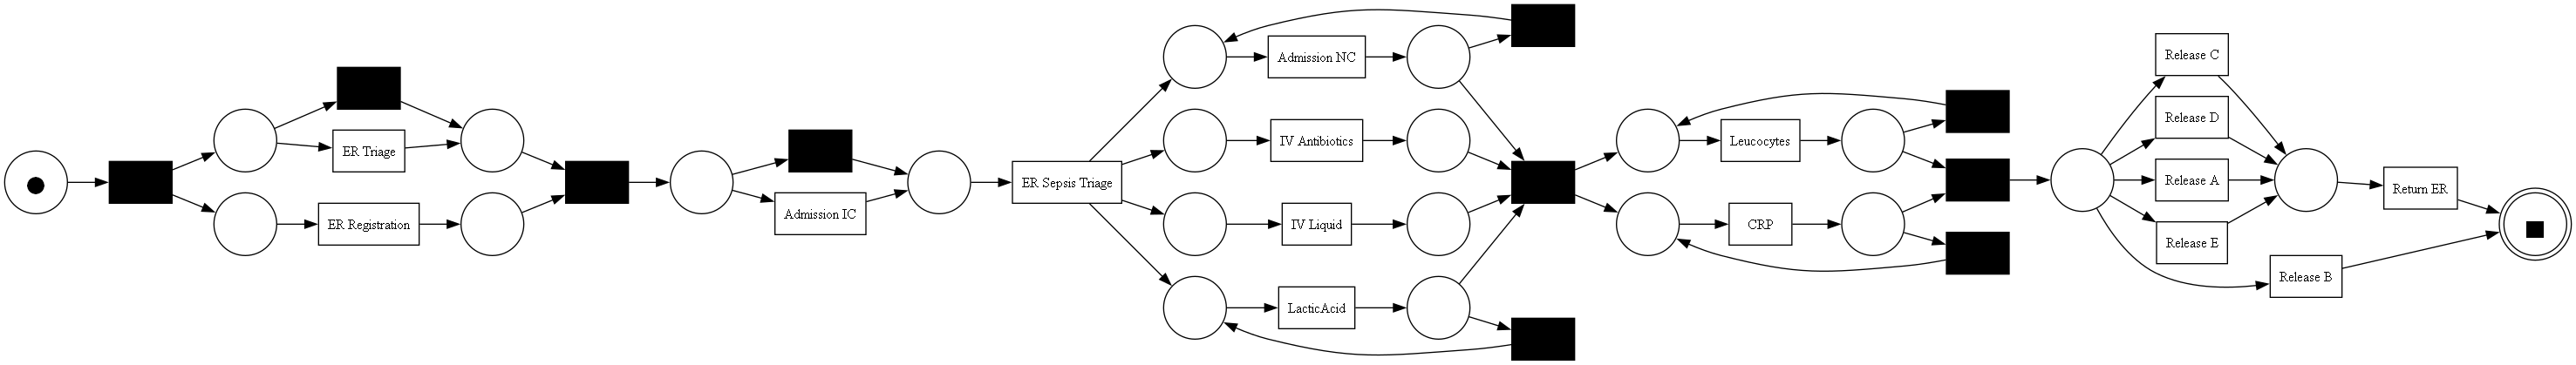

In [9]:
# Discover the model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log_df, noise_threshold=0.7)
pm4py.view_petri_net(net, im, fm, format='png')

In [10]:
current_time = datetime.now().strftime('%d-%H-%M')
# pm4py.save_vis_petri_net(net, im, fm, f'charts\\filteredLogInductivePetri_{current_time}.png')
pm4py.save_vis_petri_net(net, im, fm, rankdir='TB', file_path=f'charts\\filteredLogInductivePetri_{current_time}.png')

''

#### BPMN using the Inductive Miner

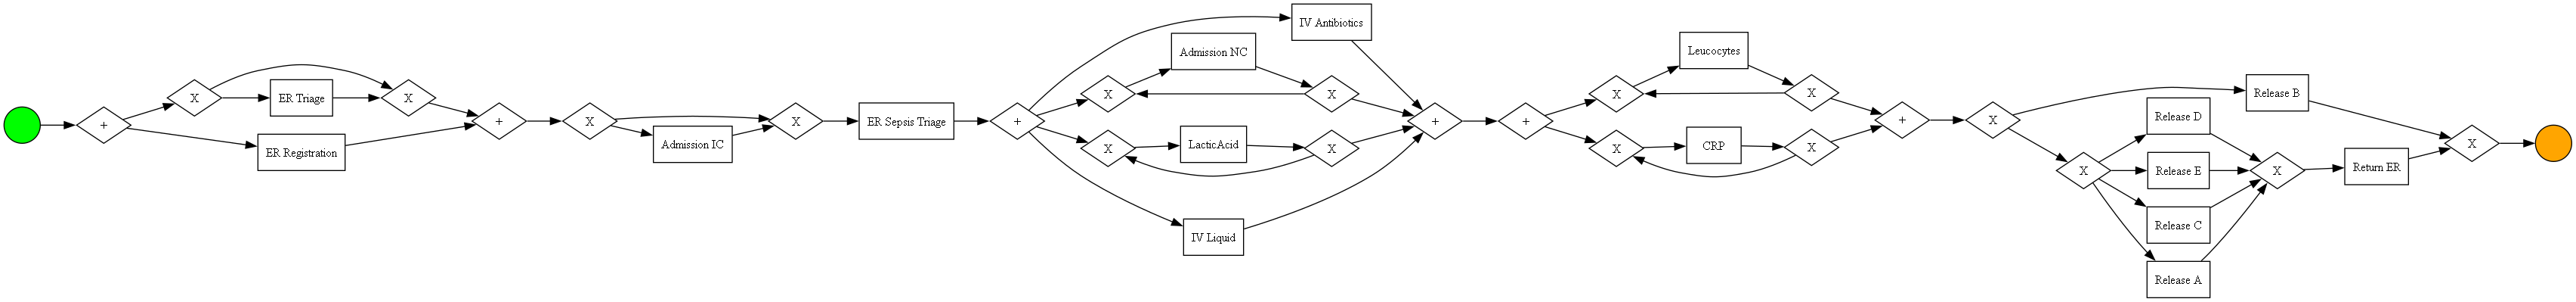

In [13]:
# bpmn_graph = pm4py.convert_to_bpmn(net, im, fm)
bpmn_graph = pm4py.discover_bpmn_inductive(filtered_log_df, activity_key='concept:name',
                                           case_id_key='case:concept:name', timestamp_key='time:timestamp',
                                           noise_threshold=0.7)
pm4py.view_bpmn(bpmn_graph)

In [12]:
current_time = datetime.now().strftime('%d-%H-%M')
pm4py.save_vis_bpmn(bpmn_graph, rankdir='TB', file_path=f'charts\\filteredLogInductiveBPMN_{current_time}.png')

''

#### Process Tree using the Inductive Miner

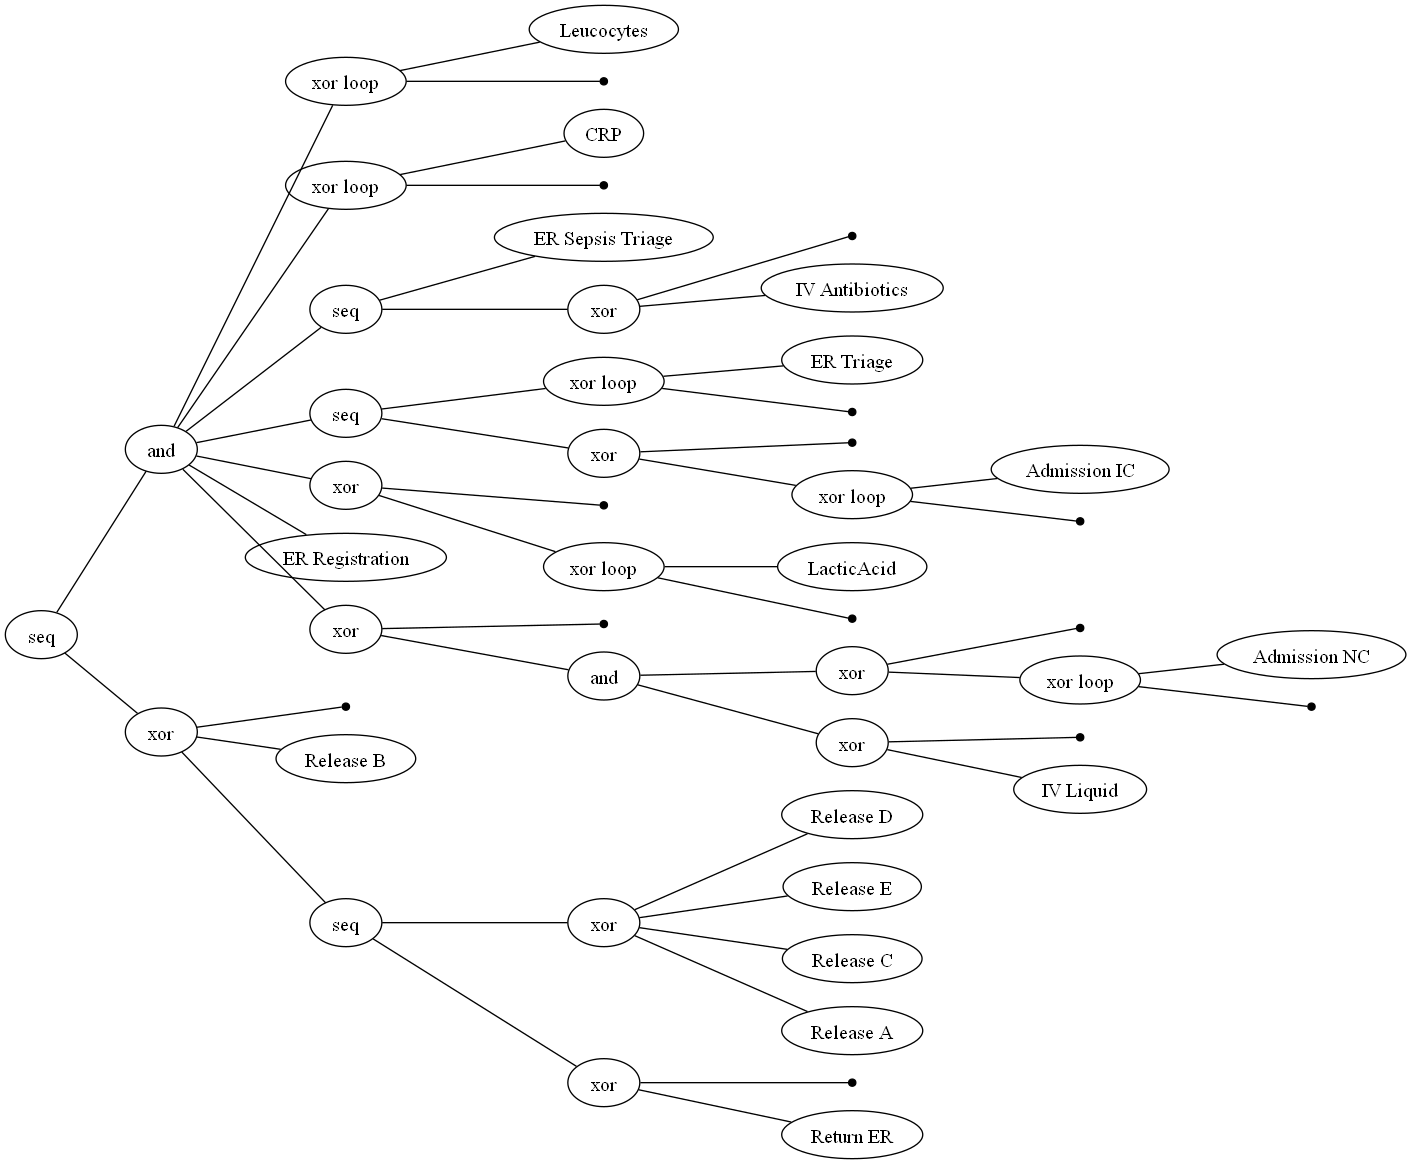

In [90]:
process_tree = pm4py.discover_process_tree_inductive(filtered_log_df, activity_key='concept:name',
                                                     case_id_key='case:concept:name', timestamp_key='time:timestamp')
pm4py.view_process_tree(process_tree, format='png')

In [196]:
current_time = datetime.now().strftime('%d-%H-%M')
pm4py.save_vis_process_tree(process_tree, f'charts\\filteredLogInductiveProcessTree_{current_time}.png')

''

In [ ]:
# Nie ma sensu tego robic

dfg, start_activities, end_activities = pm4py.discover_dfg(filtered_log_df, case_id_key='case:concept:name',
                                                           activity_key='concept:name', timestamp_key='time:timestamp')
pm4py.view_dfg(dfg, start_activities, end_activities, format='png')

#### Heuristics Miner

Number of events: 10585 (100.00%)
Number of cases: 666 (100.00%)




Heuristic Net for 99.0% cases: 
   minimum number of occurrences per activity = 7 
   and minimum number of occurrences per arc in the DF = 106


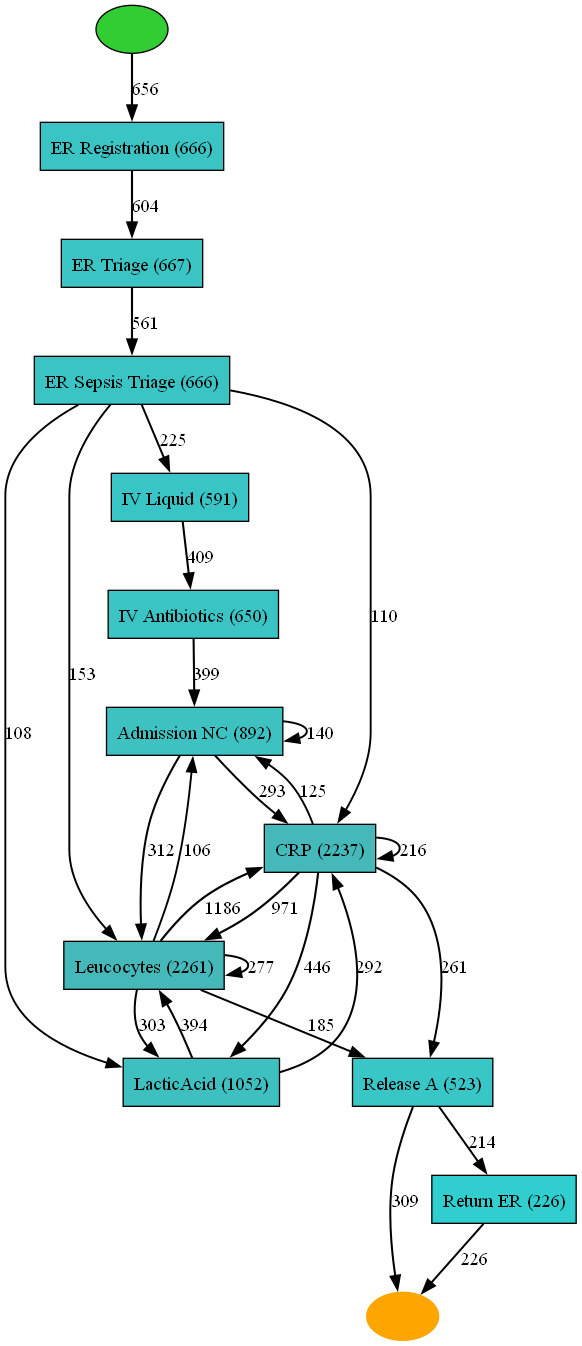

In [28]:
filtered_log_df['time:timestamp'] = pd.to_datetime(filtered_log_df['time:timestamp'])

print_log_info(filtered_log_df)
print('\n')

fragment = 1 - 0.005  # included cases
fragment = 1 - 0.01

min_act_count = round((1 - fragment) * 666)
min_dfg_occurrences = round((1 - fragment) * 10585)

print(
    f"Heuristic Net for {fragment * 100}% cases: \n   minimum number of occurrences per activity = {min_act_count} \n   and minimum number of occurrences per arc in the DF = {min_dfg_occurrences}")
heu_net = pm4py.discover_heuristics_net(filtered_log_df, activity_key='concept:name', case_id_key='case:concept:name',
                                        timestamp_key='time:timestamp', min_act_count=min_act_count,
                                        min_dfg_occurrences=min_dfg_occurrences)
pm4py.view_heuristics_net(heu_net, format='png')

In [209]:
current_time = datetime.now().strftime('%d-%H-%M')
pm4py.save_vis_heuristics_net(heu_net, f'charts\\filteredLogHeuristicNet_{fragment}_{current_time}.png')

''

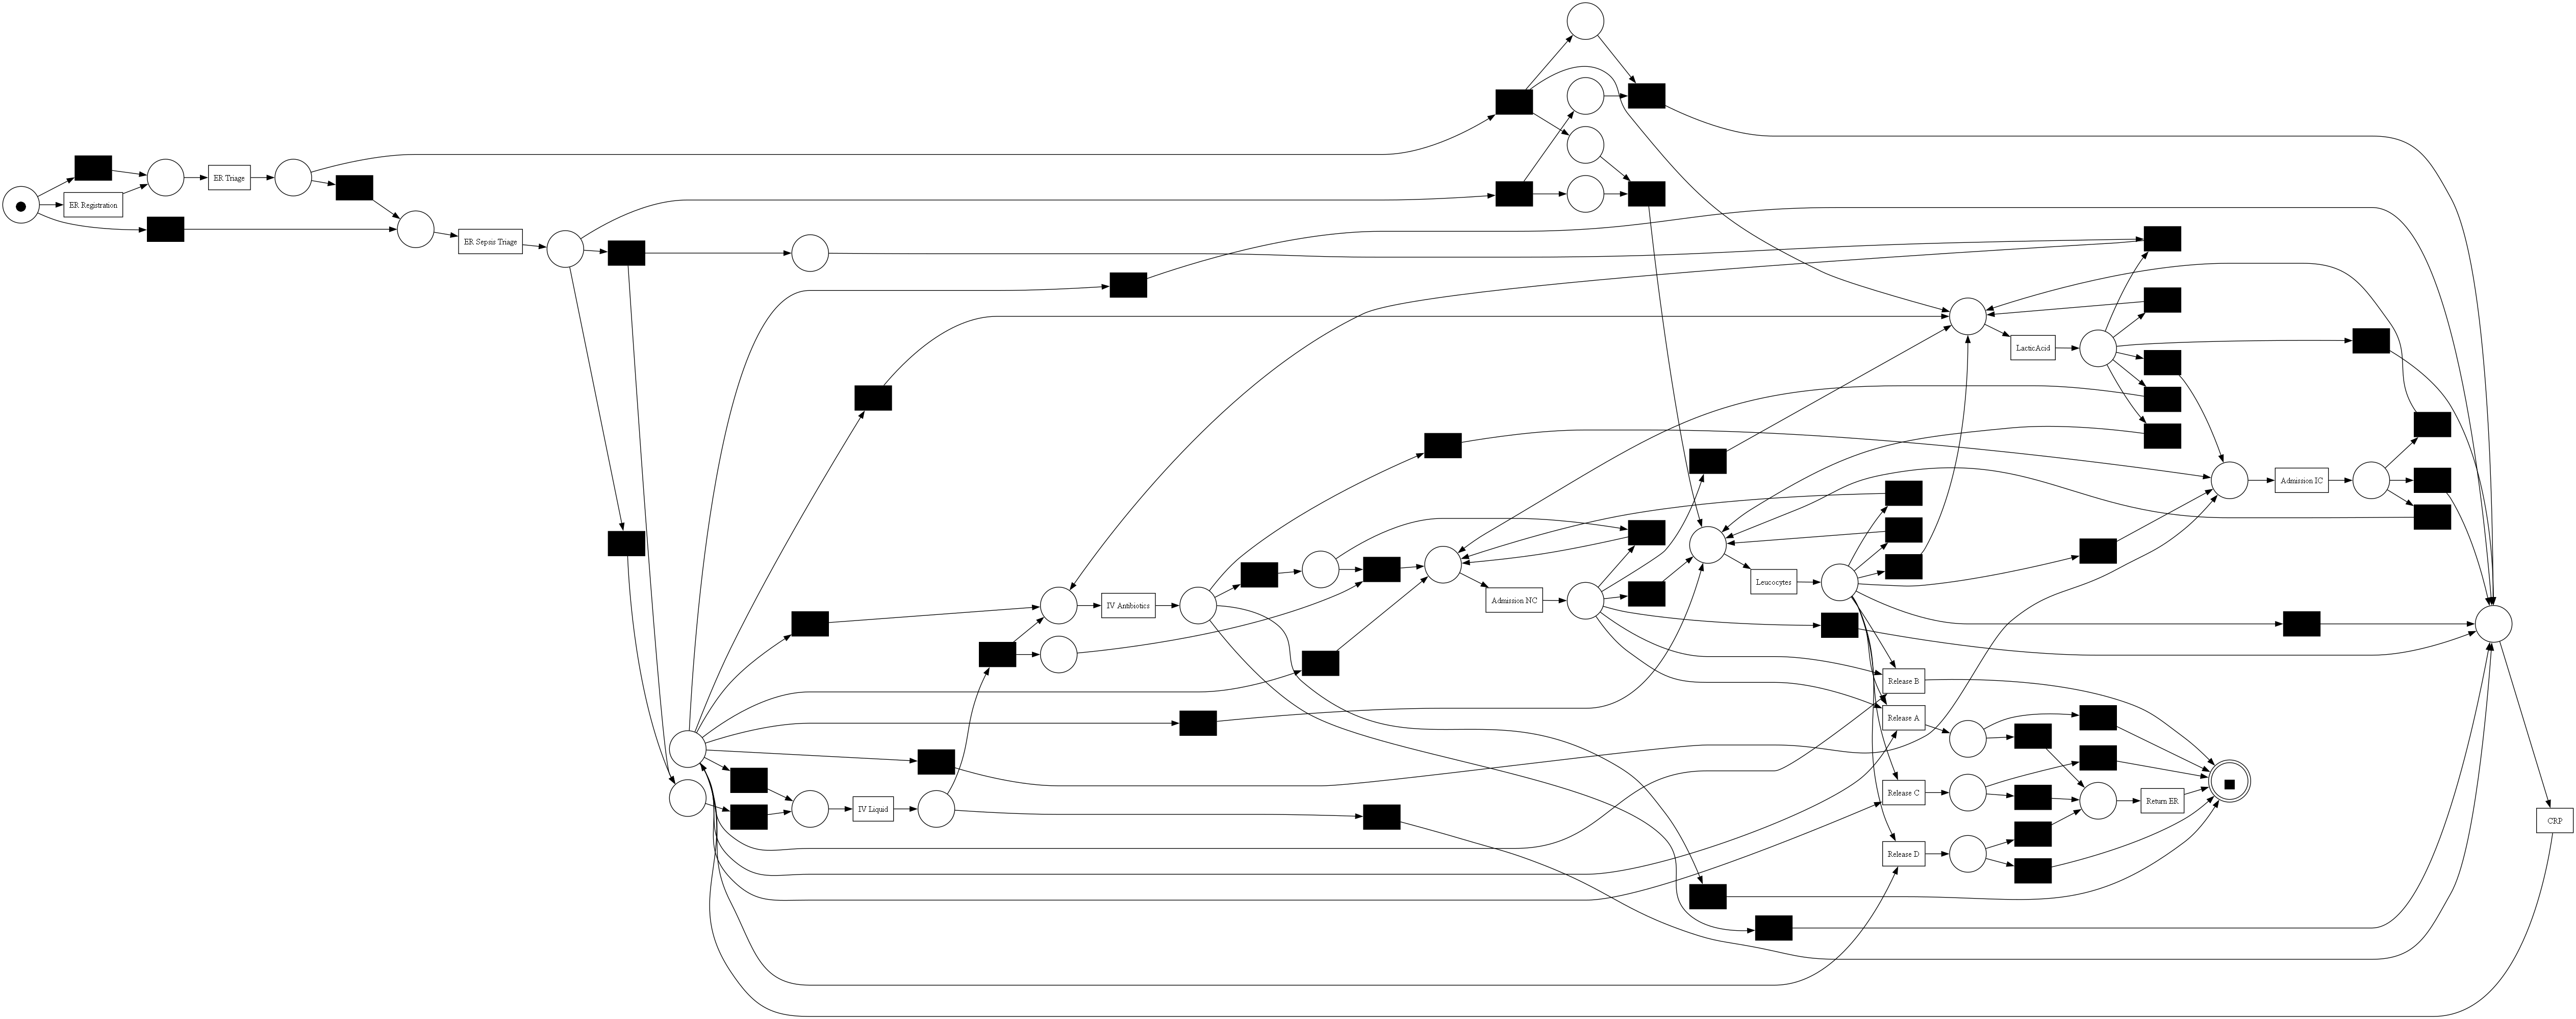

In [92]:
net, im, fm = pm4py.discover_petri_net_heuristics(filtered_log_df, dependency_threshold=0.8)

pm4py.view_petri_net(net, im, fm)

## Conformance checking:
 - Alpha Miner
 - Inductive Miner
 - Heuristic Miner

In [107]:
# Alpha Miner

net, im, fm = pm4py.discover_petri_net_alpha(filtered_log_df, activity_key='concept:name',
                                             case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_alignments = pm4py.fitness_alignments(filtered_log_df, net, im, fm, activity_key='concept:name',
                                              case_id_key='case:concept:name', timestamp_key='time:timestamp')
precision_alignments = pm4py.precision_alignments(filtered_log_df, net, im, fm, activity_key='concept:name',
                                                  case_id_key='case:concept:name', timestamp_key='time:timestamp')
gen = generalization_evaluator.apply(filtered_log_df, net, im, fm)
simp = simplicity_evaluator.apply(net)

print("FITNESS")
pprint(fitness_alignments)
print("PRECISION")
pprint(precision_alignments)
print("GENERALIZATION")
pprint(gen)
print("SIMPLICITY")
pprint(simp)

f = open("conformance\\results_15_06.txt", "a")
f.write(f"\nAlpha Miner,{fitness_alignments['averageFitness']},{precision_alignments},{gen},{simp},")
f.close()

aligning log, completed variants ::   0%|          | 0/596 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/4070 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/596 [00:00<?, ?it/s]

FITNESS
{'averageFitness': 0.6945192834265784,
 'average_trace_fitness': 0.6945192834265784,
 'log_fitness': 0.7241516331558452,
 'percFitTraces': 0.0,
 'percentage_of_fitting_traces': 0.0}
PRECISION
0.19367668978031238
GENERALIZATION
0.8894716327586962
SIMPLICITY
0.9166666666666667


In [108]:
# Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(filtered_log_df, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_alignments = pm4py.fitness_alignments(filtered_log_df, net, im, fm, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
precision_alignments = pm4py.precision_alignments(filtered_log_df, net, im, fm, activity_key='concept:name',
                                                  case_id_key='case:concept:name', timestamp_key='time:timestamp')
gen = generalization_evaluator.apply(filtered_log_df, net, im, fm)
simp = simplicity_evaluator.apply(net)

print("FITNESS")
pprint(fitness_alignments)
print("PRECISION")
pprint(precision_alignments)
print("GENERALIZATION")
pprint(gen)
print("SIMPLICITY")
pprint(simp)

f = open("conformance\\results_15_06.txt", "a")
f.write(f"\nInductive Miner,{fitness_alignments['averageFitness']},{precision_alignments},{gen},{simp},")
f.close()

aligning log, completed variants ::   0%|          | 0/596 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/4070 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/596 [00:00<?, ?it/s]

FITNESS
{'averageFitness': 1.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 0.9999210378779029,
 'percFitTraces': 100.0,
 'percentage_of_fitting_traces': 100.0}
PRECISION
0.365772149860085
GENERALIZATION
0.8722274836648507
SIMPLICITY
0.6000000000000001


In [109]:
# Heuristic Miner

net, im, fm = pm4py.discover_petri_net_heuristics(filtered_log_df, dependency_threshold=0.9, and_threshold=0.5, loop_two_threshold=0.5)
fitness_alignments = pm4py.fitness_alignments(filtered_log_df, net, im, fm, activity_key='concept:name', case_id_key='case:concept:name', timestamp_key='time:timestamp')
fitness_alignments
precision_alignments = pm4py.precision_alignments(filtered_log_df, net, im, fm, activity_key='concept:name',
                                                  case_id_key='case:concept:name', timestamp_key='time:timestamp')
gen = generalization_evaluator.apply(filtered_log_df, net, im, fm)
simp = simplicity_evaluator.apply(net)

print("FITNESS")
pprint(fitness_alignments)
print("PRECISION")
pprint(precision_alignments)
print("GENERALIZATION")
pprint(gen)
print("SIMPLICITY")
pprint(simp)

f = open("conformance\\results_15_06.txt", "a")
f.write(f"\nHeuristic Miner,{fitness_alignments['averageFitness']},{precision_alignments},{gen},{simp},")
f.close()

aligning log, completed variants ::   0%|          | 0/596 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/4070 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/596 [00:00<?, ?it/s]

FITNESS
{'averageFitness': 0.6633987974192793,
 'average_trace_fitness': 0.6633987974192793,
 'log_fitness': 0.680577746398314,
 'percFitTraces': 0.15015015015015015,
 'percentage_of_fitting_traces': 0.15015015015015015}
PRECISION
0.9794553680676095
GENERALIZATION
0.8643622047133451
SIMPLICITY
0.5


In [157]:
log_skeleton = pm4py.discover_log_skeleton(filtered_log_df, noise_threshold=0.1, activity_key='concept:name',
                                           case_id_key='case:concept:name', timestamp_key='time:timestamp')


In [162]:
import json

# Discover the log skeleton
log_skeleton = pm4py.discover_log_skeleton(filtered_log_df,
                                           noise_threshold=0.1,
                                           activity_key='concept:name',
                                           case_id_key='case:concept:name',
                                           timestamp_key='time:timestamp')


# Function to convert sets to lists within a dictionary
def convert_sets_to_lists(obj):
    if isinstance(obj, dict):
        return {k: convert_sets_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, set):
        return list(obj)
    elif isinstance(obj, list):
        return [convert_sets_to_lists(item) for item in obj]
    else:
        return obj


# Convert sets to lists
log_skeleton_serializable = convert_sets_to_lists(log_skeleton)

# Save to JSON file
with open('results\\log_skeleton.json', 'w') as fp:
    json.dump(log_skeleton_serializable, fp)

In [183]:
print("'always_after' - specifies that some activities should always trigger the execution of some other activities")
pprint(log_skeleton['always_after'])
print('\n')
print("'directly_follows' - specifies for some activities some strict bounds on the activities directly-following")
pprint(log_skeleton['directly_follows'])
print('\n')
print("'activ_occurrences' - specifies the allowed number of occurrences per activity")
pprint(log_skeleton['activ_freq'], width=100)

'always_after' - specifies that some activities should always trigger the execution of some other activities
{('Release A', 'Return ER'),
 ('Release C', 'Return ER'),
 ('Release D', 'Return ER'),
 ('Release E', 'Return ER')}


'directly_follows' - specifies for some activities some strict bounds on the activities directly-following
{('ER Registration', 'ER Triage')}


'activ_occurrences' - specifies the allowed number of occurrences per activity
{'Admission IC': {0, 1, 2},
 'Admission NC': {0, 1, 2, 3, 4, 5},
 'CRP': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 24, 36, 69},
 'ER Registration': {1},
 'ER Sepsis Triage': {1},
 'ER Triage': {1, 2},
 'IV Antibiotics': {0, 1},
 'IV Liquid': {0, 1},
 'LacticAcid': {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 37, 11, 12, 13, 15, 26, 31},
 'Leucocytes': {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 21, 22, 24, 38, 74},
 'Release A': {0, 1},
 'Release B': {0, 1},
 'Release C': {0, 1},
 'Release D': {0, 1},
 'Release E': {0, 1},
 'Ret